# Kpop-music Search Engine Code Pipeline

### Libraries

In [2]:
import gzip
import json
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from indexing import IndexType, Indexer
from document_preprocessor import RegexTokenizer
from indexing import InvertedIndex, BasicInvertedIndex
from ranker import BM25, RandomScorer, PopularityScorer
from l2r_baseline import LambdaMART, L2RFeatureExtractor, L2RRanker
import relevance
from ranker import Ranker
from ranker import BM25

### Part1: Feature Importances Analysis

#### Indexing

In [ ]:
stopwords = set()
with open('tests/stopwords.txt', 'r', encoding='utf-8') as file:
    for stopword in file:
        stopwords.add(stopword)
        
preprocessor = RegexTokenizer('\w+')
main_index = Indexer.create_index(
            IndexType.BasicInvertedIndex, 'data/kpop_tracks.jsonl.gz', preprocessor, stopwords, minimum_word_frequency=0)

In [ ]:
main_index.save('data/main_index')

In [ ]:
title_index = Indexer.create_index(
            IndexType.BasicInvertedIndex, 'data/kpop_tracks.jsonl.gz', preprocessor, stopwords, 0, text_key='title')

title_index.save('data/title_index')

In [3]:
doc_index = BasicInvertedIndex()
doc_index.load('data/main_index')

title_index = BasicInvertedIndex()
title_index.load('data/title_index')

#### L2R Ranker Training and Evaluation

In [5]:
stopwords = set()
with open('data/stopwords.txt', 'r', encoding='utf-8') as file:
    for stopword in file:
        stopwords.add(stopword)


l2r_feature_extractor = L2RFeatureExtractor(document_index=doc_index, title_index=title_index, 
                                             document_preprocessor=RegexTokenizer('\w+'),
                                            stopwords=stopwords)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [6]:

l2r_ranker = L2RRanker(document_index=doc_index, title_index=title_index, document_preprocessor=RegexTokenizer('\w+'),
                       stopwords=stopwords, scorer=BM25(doc_index),
                       feature_extractor=l2r_feature_extractor)

In [7]:
l2r_ranker.train('data/train.csv')

Processing Queries: 100%|██████████| 5/5 [01:27<00:00, 17.58s/it]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 671
[LightGBM] [Info] Number of data points in the train set: 2105, number of used features: 7


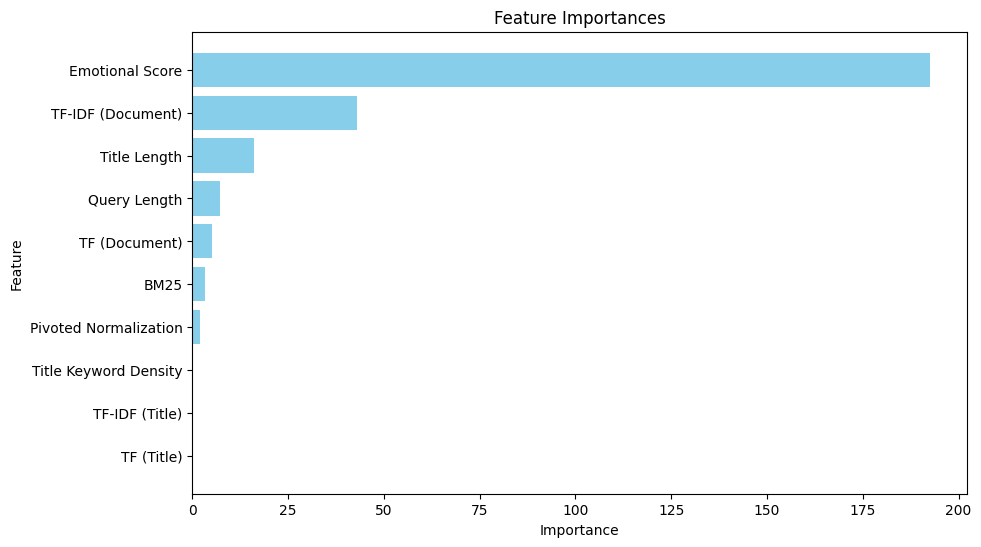

In [ ]:
def plot_selected_feature_importances(model, feature_names):
    importances = model.feature_importances_[:len(feature_names)]  

    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.barh(range(len(importances)), importances[indices], align='center', color='skyblue')
    plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.gca().invert_yaxis()  
    plt.show()

feature_names = [
    'Title Length', 'Query Length',
    'TF (Document)', 'TF-IDF (Document)', 'TF (Title)', 'TF-IDF (Title)',
    'BM25', 'Pivoted Normalization', 
    'Title Keyword Density', 'Emotional Score'
]

plot_selected_feature_importances(l2r_ranker.model.model, feature_names)


### Part2: Five Search Engine Models Evaluations

#### Simple Ranker Based on Popularity (Baseline0)

In [14]:
stopwords = set()
with open('data/stopwords.txt', 'r', encoding='utf-8') as file:
    for stopword in file:
        stopwords.add(stopword)
baseline0 = RandomScorer(doc_index)
baseline0_ranker = Ranker(doc_index, RegexTokenizer('\w+'), stopwords, baseline0)
baseline0_ranker_test = relevance.run_relevance_tests('data/test.csv', baseline0_ranker)

Evaluating: 100%|██████████| 3/3 [00:00<00:00, 624.74it/s]


In [26]:
baseline0_ranker_test

{'map': 0.032898715041572185,
 'ndcg': 0.05170773594040659,
 'map_list': [0.0, 0.04563492063492063, 0.05306122448979592],
 'ndcg_list': [0.0, 0.052297694662585804, 0.10282551315863396]}

#### BM25 Ranker (Baseline1)

In [16]:
bm25 = BM25(doc_index)
bm25_ranker = Ranker(doc_index, RegexTokenizer('\w+'), stopwords, bm25)

In [17]:
train_data = pd.read_csv('data/train.csv')
train_data.head(1)

,query,title,docid,text,rel
0,Quite and soft music for study background,Dynamite,0,"[Intro: Jung Kook]\n'Cause I, I, I'm in the st...",4


In [18]:
bm25_ranker_test = relevance.run_relevance_tests('data/test.csv', bm25_ranker)

Evaluating: 100%|██████████| 3/3 [00:00<00:00, 201.13it/s]


In [19]:
bm25_ranker_test['map'], bm25_ranker_test['ndcg']

(0.016754062736205593, 0.024218442068188826)

#### L2R Ranker Without User History Data

In [20]:
from l2r_baseline import L2RFeatureExtractor, L2RRanker

In [21]:
l2r_feature_extractor = L2RFeatureExtractor(document_index=doc_index, title_index=title_index, 
                                             document_preprocessor=RegexTokenizer('\w+'),
                                            stopwords=stopwords)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [22]:

l2r_no_history_ranker = L2RRanker(document_index=doc_index, title_index=title_index, document_preprocessor=RegexTokenizer('\w+'),
                       stopwords=stopwords, scorer=BM25(doc_index),
                       feature_extractor=l2r_feature_extractor)

In [23]:
l2r_no_history_ranker.train('data/train.csv')

Processing Queries: 100%|██████████| 5/5 [01:29<00:00, 17.97s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 671
[LightGBM] [Info] Number of data points in the train set: 2105, number of used features: 7


In [25]:
l2r_no_history_ranker_test = relevance.run_relevance_tests('data/test.csv', l2r_no_history_ranker)
l2r_no_history_ranker_test['map'], l2r_no_history_ranker_test['ndcg']

Evaluating: 100%|██████████| 3/3 [00:11<00:00,  3.87s/it]


(0.023875661375661373, 0.03323915167012365)

#### L2R Ranker With User History Data

In [ ]:
l2r_feature_extractor = L2RFeatureExtractor(document_index=doc_index, title_index=title_index, 
                                             document_preprocessor=RegexTokenizer('\w+'),
                                            stopwords=stopwords)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [24]:
from l2r import L2RFeatureExtractor, L2RRanker
l2r_ranker = L2RRanker(document_index=doc_index, title_index=title_index, document_preprocessor=RegexTokenizer('\w+'),
                       stopwords=stopwords, scorer=BM25(doc_index),
                       feature_extractor=l2r_feature_extractor, datapath='data/data.jsonl', historypath='data/history.csv')

In [25]:
l2r_ranker.train('data/train.csv')

Processing Queries: 100%|██████████| 5/5 [01:31<00:00, 18.40s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 671
[LightGBM] [Info] Number of data points in the train set: 2105, number of used features: 7


In [ ]:
lgb_ranker = relevance.run_relevance_tests('data/test.csv', l2r_ranker)
lgb_ranker['map'], lgb_ranker['ndcg']

Evaluating: 100%|██████████| 3/3 [00:12<00:00,  4.15s/it]


(0.11550925925925926, 0.04069488591783219)

#### L2R Ranker Using Query Subtitution

In [ ]:
from l2r import L2RFeatureExtractor, L2RRanker

In [30]:
lgb_ranker_with_query_substitution = relevance.run_relevance_tests('data/test.csv', l2r_ranker)
lgb_ranker_with_query_substitution['map'], lgb_ranker_with_query_substitution['ndcg']

Evaluating: 100%|██████████| 3/3 [00:10<00:00,  3.45s/it]


(0.023875661375661373, 0.03323915167012365)

#### Visualization

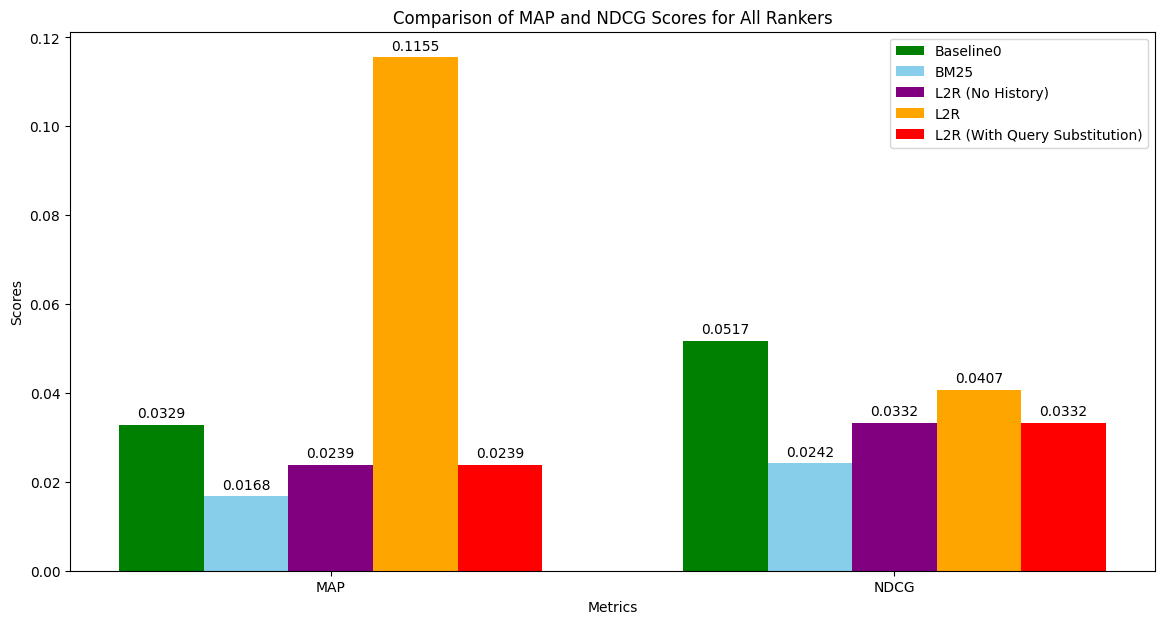

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Scores for each ranker
baseline0_scores = [baseline0_ranker_test['map'], baseline0_ranker_test['ndcg']]
bm25_scores = [bm25_ranker_test['map'], bm25_ranker_test['ndcg']]
l2r_no_history_scores = [l2r_no_history_ranker_test['map'], l2r_no_history_ranker_test['ndcg']]
l2r_scores = [lgb_ranker['map'], lgb_ranker['ndcg']]
l2r_with_query_substitution_scores = [lgb_ranker_with_query_substitution['map'], lgb_ranker_with_query_substitution['ndcg']]

# Labels for the metrics
score_labels = ['MAP', 'NDCG']

# Setup bar positions and width
x = np.arange(len(score_labels))  
width = 0.15  # Adjust width to accommodate five bars

# Create the figure and axes
fig, ax = plt.subplots(figsize=(14, 7))

# Plot bars for each ranker
baseline0_bars = ax.bar(x - 2 * width, baseline0_scores, width, label='Baseline0', color='green')
bm25_bars = ax.bar(x - width, bm25_scores, width, label='BM25', color='skyblue')
l2r_no_history_bars = ax.bar(x, l2r_no_history_scores, width, label='L2R (No History)', color='purple')
l2r_bars = ax.bar(x + width, l2r_scores, width, label='L2R', color='orange')
l2r_with_query_substitution_bars = ax.bar(x + 2 * width, l2r_with_query_substitution_scores, width, label='L2R (With Query Substitution)', color='red')

# Add labels and titles
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of MAP and NDCG Scores for All Rankers')
ax.set_xticks(x)
ax.set_xticklabels(score_labels)
ax.legend()

# Function to add score labels above bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',  # Label with four decimal places
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels for each group of bars
add_labels(baseline0_bars)
add_labels(bm25_bars)
add_labels(l2r_no_history_bars)
add_labels(l2r_bars)
add_labels(l2r_with_query_substitution_bars)

# Display the plot
plt.show()


### Part3: Search Engine Demo

In [64]:
initial_ranking = l2r_ranker.query('Stray Kids')

In [ ]:
from filter import filter_tracks

jsonl_path = 'data/data.jsonl'
artist_name = 'Stray Kids'
danceability_range = (0.5, 0.9)
energy_range = (0.7, 1.0)
release_year_range = (2019, 2023)
docid_list = [item[0] for item in initial_ranking]

filtered_tracks = filter_tracks(
    jsonl_path=jsonl_path,
    artist_name=artist_name,
    danceability_range=danceability_range,
    energy_range=energy_range,
    release_year_range=release_year_range,
    docid_list=docid_list
)

for track in filtered_tracks:
    print(track)

{'title': 'MANIAC', 'artists': 'Stray Kids', 'release_date': '2022-03-18', 'danceability': 0.581, 'energy': 0.8, 'original_lyrics': '[스트레이 키즈 "MANIAC" 가사]\n[Intro: Felix]\nLet\'s go\n[Refrain: Bang Chan, \nHyunjin\n]\n정상인 척 다들 힘 좀 빼\n짓고 있는 미소들은 쎄해\nLock이 풀리면 다 똑같지\n눈은 날 못 속여, ho\n[Verse 1: I.N, \nLee Know\n, \nSeungmin\n, \nHan\n]\n본체는 풀렸네 (\nYup, yup\n)\n정신을 간신히 잡지 (\nYup, yup\n)\n눈 한번 깜빡이고 back\n다시 세상이 정한 정상인 cosplay, 준비, pow\n[Pre-Chorus: Han, \nChangbin\n]\nMash up, mind blown, 정신은 back up\nPrototype 내 속은 언제나 freaky monster\n유행 같은 친절함은 철이 지나, rotten\n내 통수에 다 시원하게 욕해도 다 먹금\nPoppin\'\n순진하게만 보다가 크게 다침\n호의가 계속되면 권리인 줄 아네, toxic\n이러니 돌지, warning\n[Chorus: Felix, \nHan\n, \nHyunjin\n, \nChangbin\n, (Bang Chan)]\nManiac\n나사 빠진 것처럼 미쳐, maniac\n핑핑 돌아버리겠지\nManiac, Frankenstein처럼 걸어\nManiac, maniac (\nHa-ha\n)\nManiac\n (Oh)\n나사 빠진 것처럼 웃어 maniac\n (You can\'t stop the smoke)\n핑핑 돌아버리겠지\n (Thick as fog)\nManiac, 비정상투성이 집단\n (We\'re maniacs)\nManiac, maniac\n[Verse 2: Seungmin, \nFelix\n, \nHan